In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import pymc3 as pm
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_probability as tfp
tfd = tfp.distributions

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Mixed model with pooled variance

Group-specific mean prior (for each of $m$ groups):

$$\large \beta_{mj} \sim \mathcal{N}(\mu_{\beta m}, \sigma_{\beta m}) $$


Common variance prior:

$$\large \sigma \sim \mathcal{HN}(\sigma_{\sigma})$$


Mean parametrization:

$$\large \mu_j = \beta_{1j}X_1 + \dots + \beta_{m}X_m$$


Posterior:

$$\large Y \sim \mathcal{N}(\mu_j, \sigma)$$

### Data + EDA

In [3]:
# Get food data
data = pd.read_csv('data/food_sales.csv')

In [4]:
data.shape

(468, 3)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customers      468 non-null    int64  
 1   sales          468 non-null    float64
 2   Food_Category  468 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 11.1+ KB


In [6]:
data.head()

,customers,sales,Food_Category
0,31,459.89520,Pizza
1,31,401.14774,Pizza
2,31,413.34525,Pizza
3,31,371.90924,Pizza
4,32,433.79710,Pizza


In [7]:
data['Food_Category'].unique()

array(['Pizza', 'Sandwich', 'Salad'], dtype=object)

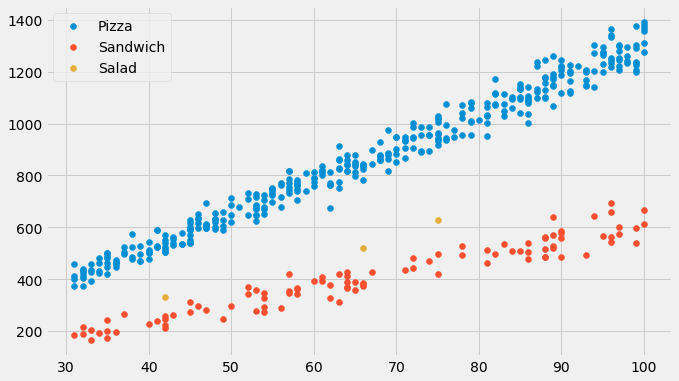

In [8]:
# Plot 
plt.figure(figsize=(10, 6))
for food_type in data.Food_Category.unique():
    _data = data[data['Food_Category'] == food_type]
    plt.scatter(_data.customers, _data.sales, label=food_type)
plt.legend()
plt.show()

In [9]:
data['sales'].min(), data[data['Food_Category'] == 'Sandwich']['sales'].std()

(164.00851, 134.65233268840495)

### Model with interaction

In [21]:
# Get observations
sales = data['sales']
n_customers = data['customers']
food_as_cat = pd.Categorical(data['Food_Category'])
food_cat = food_as_cat.codes

In [11]:
# Model
with pm.Model() as model_with_interaction:
    
    # Prior
    sigma = pm.HalfNormal('sigma', 20)
    beta = pm.Normal('beta', mu=10, sigma=100, shape=3)
    
    # Likelihood
    mu = pm.Deterministic(
        'mu',
        beta[food_cat] * n_customers
    )
    
    # Posterior
    sales_model = pm.Normal('sales', mu=mu, sigma=sigma, observed=sales) 
    
    
    # Get trace
    trace_model_pooled_sigma = pm.sample()
    
    # Get posterior predictive
    posterior_pred_model_sigma_pooled = pm.sample_posterior_predictive(
        trace_model_pooled_sigma
    )
    
    # Get inference data
    inf_data_model_pooled_sigma = az.from_pymc3(
        trace=trace_model_pooled_sigma,
        posterior_predictive=posterior_pred_model_sigma_pooled,
        coords={'beta_dim_0': pd.Categorical(data['Food_Category']).categories}
    )

C:\Users\aleks\AppData\Local\Temp/ipykernel_26848/1567867922.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_model_pooled_sigma = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


In [12]:
# Summarize
az.summary(inf_data_model_pooled_sigma, var_names=['beta', 'sigma']).round(1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Pizza],13.0,0.0,13.0,13.1,0.0,0.0,6763.0,2808.0,1.0
beta[Salad],8.1,0.4,7.5,8.8,0.0,0.0,5856.0,2790.0,1.0
beta[Sandwich],6.1,0.1,6.0,6.2,0.0,0.0,6890.0,3042.0,1.0
sigma,39.3,1.3,37.0,41.7,0.0,0.0,6122.0,3144.0,1.0


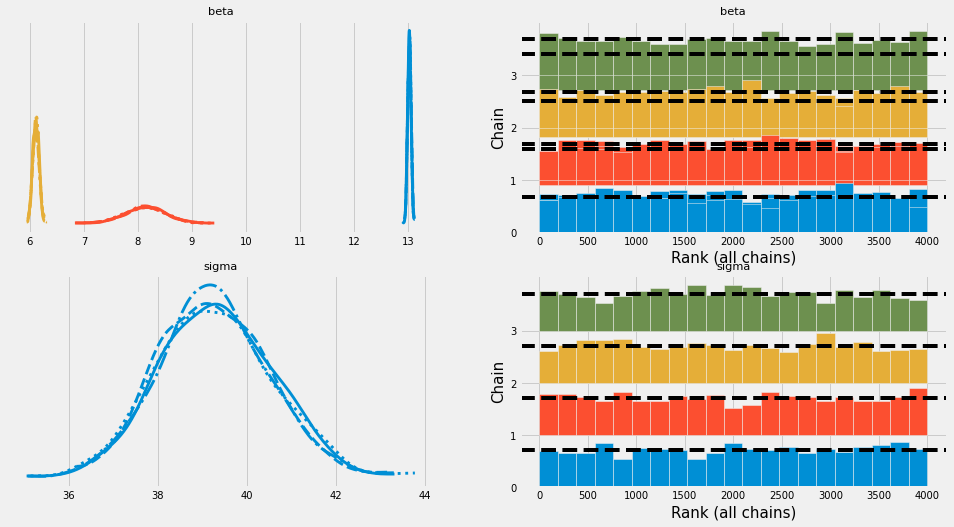

In [13]:
# Plot traces
az.plot_trace(
    inf_data_model_pooled_sigma, 
    var_names=['beta', 'sigma'],
    compact=True, 
    figsize=(15, 8),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

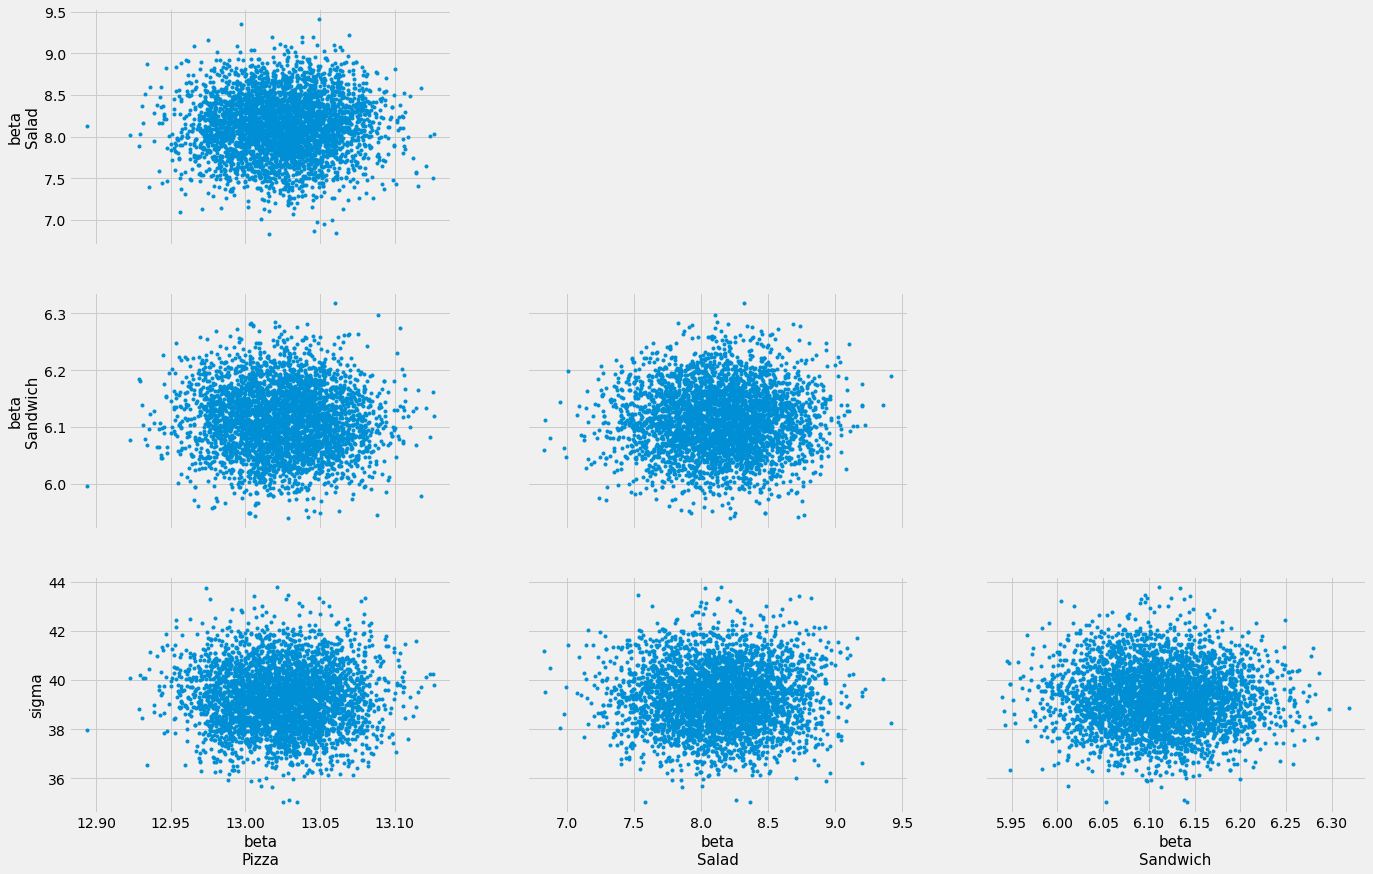

In [14]:
# Check divergences
az.plot_pair(inf_data_model_pooled_sigma, divergences=True, var_names=['beta', 'sigma'])
plt.show()

In [33]:
# Get predicitons for salad
beta_salad = trace_model_pooled_sigma['beta'][:, np.where(food_as_cat.categories == 'Salad')[0][0]]

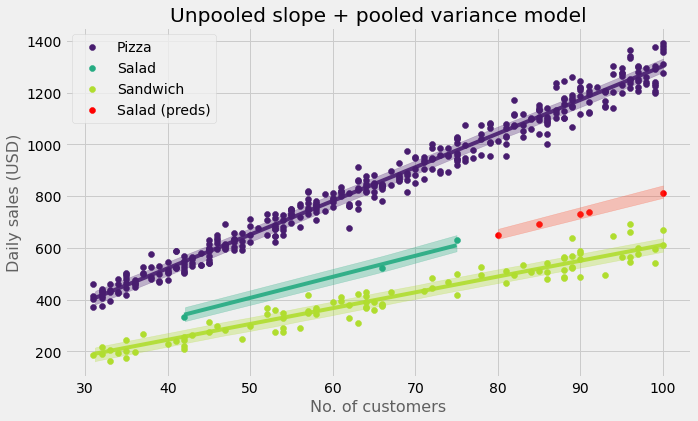

In [76]:
# Get fig & axes
_, ax = plt.subplots(1, figsize=(10, 6))

# Get sigma
sigma_mean = inf_data_model_pooled_sigma.posterior['sigma'].mean().values

# Get and plot reg lines
for i in range(food_cat.max() + 1):
    cat_mask = food_cat == i
    mu_mean = inf_data_model_pooled_sigma.posterior['mu'][:, :, cat_mask].mean(axis=(0, 1))
    ax.plot(data['customers'][cat_mask], mu_mean, color=viridish[i], alpha=.9)
    az.plot_hdi(
        data['customers'][cat_mask], 
        inf_data_model_pooled_sigma.posterior_predictive['sales'][:, :, cat_mask],
        hdi_prob=.5,
        ax=ax,
        fill_kwargs={'alpha': .3},
        color=viridish[i]
    )
    
    # Get scatter
    food_type = pd.Categorical(data['Food_Category']).categories[i]
    _data = data[data['Food_Category'] == food_type]
    ax.scatter(_data.customers, _data.sales, label=food_type, color=viridish[i])
    
# Plot preds for new salad obs
new_salad_obs = np.array([80, 85, 90, 91, 100])
ax.scatter(new_salad_obs, beta_salad.mean() * new_salad_obs, color='red', label='Salad (preds)')
az.plot_hdi(
    new_salad_obs, 
    np.outer(beta_salad, new_salad_obs).reshape(4, 1000, 5),
    hdi_prob=.5,
    ax=ax,
    fill_kwargs={'alpha': .3}
)

# Add labels
ax.set_xlabel('No. of customers', alpha=.6, fontsize=16)
ax.set_ylabel('Daily sales (USD)', alpha=.6, fontsize=16)
ax.set_title('Unpooled slope + pooled variance model')

plt.legend()
plt.show()

In [50]:
beta_salad.std()

0.3610851939751433